## Diamond Price Prediction
In this project, I'm going to explore the relationship between features and price of dimonds. The goal is to predict the price of diamonds using variables that describe the quality of diamonds such as carat, cut and clarity.

In [1]:
import findspark
findspark.init("C:\spark-2.4.5-bin-hadoop2.7\spark-2.4.5-bin-hadoop2.7") 

In [2]:
findspark.find()

'C:\\spark-2.4.5-bin-hadoop2.7\\spark-2.4.5-bin-hadoop2.7'

In [24]:
#Import Classes
import pandas as pd
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
from statsmodels.graphics.mosaicplot import mosaic
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType 
from pyspark.sql.types import DoubleType 
from pyspark.sql.functions import udf 
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
import functools 
import numpy as np
import operator

In [25]:
import pyspark
sc = pyspark.SparkContext() 

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-6-856dd384d865>:1 

#### 1. Read the Data

In [26]:
sqlContext = SQLContext(sc)
schema = StructType([
    StructField("carat", DoubleType()),
    StructField("cut", StringType()),
    StructField("color", StringType()),
    StructField("clarity", StringType()),
    StructField("depth", DoubleType()),
    StructField("table", IntegerType()),
    StructField("price", IntegerType()),
    StructField("x", DoubleType()),
    StructField("y", DoubleType()),
    StructField("z", DoubleType())
])
diamonds_df=sqlContext.read.csv(
    "data/diamonds.csv", header=True, mode="DROPMALFORMED",schema=schema
)

#### 2. Data Exploration

In [30]:
#Get a glimpse of dataset -  columns etc
display(diamonds_df)

DataFrame[carat: double, cut: string, color: string, clarity: string, depth: double, table: int, price: int, x: double, y: double, z: double]

In [31]:
diamonds_df.head(10)

[Row(carat=0.23, cut='Ideal', color='E', clarity='SI2', depth=61.5, table=55, price=326, x=3.95, y=3.98, z=2.43),
 Row(carat=0.21, cut='Premium', color='E', clarity='SI1', depth=59.8, table=61, price=326, x=3.89, y=3.84, z=2.31),
 Row(carat=0.23, cut='Good', color='E', clarity='VS1', depth=56.9, table=65, price=327, x=4.05, y=4.07, z=2.31),
 Row(carat=0.29, cut='Premium', color='I', clarity='VS2', depth=62.4, table=58, price=334, x=4.2, y=4.23, z=2.63),
 Row(carat=0.31, cut='Good', color='J', clarity='SI2', depth=63.3, table=58, price=335, x=4.34, y=4.35, z=2.75),
 Row(carat=0.24, cut='Very Good', color='J', clarity='VVS2', depth=62.8, table=57, price=336, x=3.94, y=3.96, z=2.48),
 Row(carat=0.24, cut='Very Good', color='I', clarity='VVS1', depth=62.3, table=57, price=336, x=3.95, y=3.98, z=2.47),
 Row(carat=0.26, cut='Very Good', color='H', clarity='SI1', depth=61.9, table=55, price=337, x=4.07, y=4.11, z=2.53),
 Row(carat=0.22, cut='Fair', color='E', clarity='VS2', depth=65.1, table=

#### 3. Define Target variable and segregate into categorical and numerical variables

In [32]:
cat_var = [ t[0]  for t in diamonds_df.dtypes if t[1]=='string']
target = 'price'
num_var = list(set(diamonds_df.columns)-set(cat_var)-set([target]))

#### 4. Summarize numerical columns

In [33]:
#for the numeric fields find the min,max, std dev
display(diamonds_df[num_var].describe().toPandas())  
#0's indicate missing values

,summary,table,y,x,depth,z,carat
0,count,53016,53016,53016,53016,53016,53016
1,mean,57.476063829787236,5.736620454202406,5.733946921683916,61.74920024143587,3.539653878074697,0.7991279990945847
2,stddev,2.225280761946626,1.1441409689206954,1.1234684592725532,1.4364417227925113,0.6960828347336051,0.4746344972873768
3,min,43,0.0,0.0,43.0,0.0,0.2
4,max,95,58.9,10.74,79.0,8.06,5.01


In [34]:
# Replace 0's with NAs
get_null_label = udf(lambda x: None if x <= 0 else x, DoubleType())
diamonds_df = diamonds_df.withColumn("x", get_null_label(diamonds_df["x"]))
diamonds_df = diamonds_df.withColumn("y", get_null_label(diamonds_df["y"]))
diamonds_df = diamonds_df.withColumn("z", get_null_label(diamonds_df["z"]))

In [35]:
display(diamonds_df[num_var].describe().toPandas()) 

,summary,table,y,x,depth,z,carat
0,count,53016,53009,53008,53016,52996,53016
1,mean,57.476063829787236,5.737377992416283,5.73481229248405,61.74920024143587,3.5409896973358013,0.7991279990945847
2,stddev,2.225280761946626,1.1423156569557014,1.121342516378658,1.4364417227925113,0.692808747468875,0.4746344972873768
3,min,43,3.68,3.73,43.0,1.07,0.2
4,max,95,58.9,10.74,79.0,8.06,5.01


#### 5. Check the distribution of categorical variables 
###### Hypothesis 1. Colourless Diamonds (code D-F) generally cost more, is this evident from the dataset?


In our dataset colorless diamonds are less costly than colored ones, as evident from the plot below. 

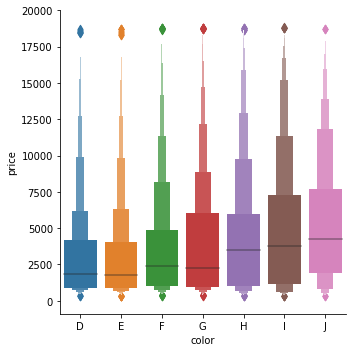

In [36]:
sns.catplot(x='color', y="price", kind="boxen",
            data=diamonds_df.toPandas().sort_values('color'));

More diamonds of color G, followed by E, F. 
Very few diamonds have color J

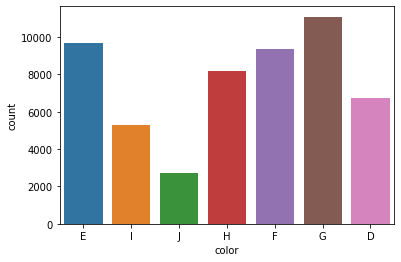

In [41]:
sns.countplot(x='color',data=diamonds_df.toPandas())

###### Hypothesis 2. Do flawless diamonds cost more than those with significant inclusions?
No clear pattern seen

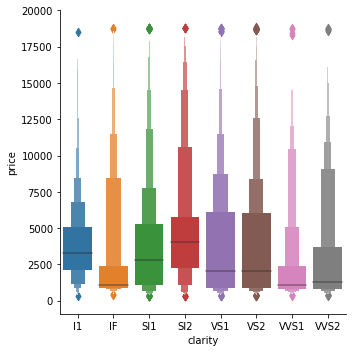

In [42]:
sns.catplot(x='clarity', y="price", kind="boxen",
            data=diamonds_df.toPandas().sort_values('clarity'));

SI1 most common and I1 least common

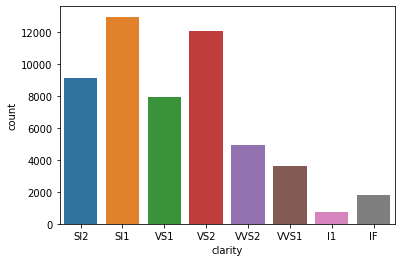

In [43]:
sns.countplot(x='clarity',data=diamonds_df.toPandas())

###### Hypothesis 3. Do ideal cuts fetch more price than fair ones?
Again, no clear pattern. Ideal cut seems to be the least priced and premium, most priced.

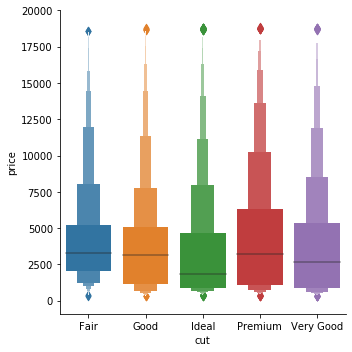

In [47]:
sns.catplot(x='cut', y="price", kind="boxen",
            data=diamonds_df.toPandas().sort_values('cut'));

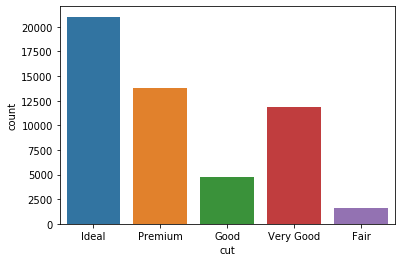

In [48]:
sns.countplot(x='cut',data=diamonds_df.toPandas())

###### Traditionally, colorless diamonds (nearer to D) are priced more. But from our dataset , we can see that median prices for faintly coloured diamonds(J) is more than that for colorless. This maybe due to the fact some edgier designs look better with coloured diamonds and can be a recent change in customer preference or there might be other variables which influence the price much more. Similarly IF (internally flawless) diamonds have lesser median price than I1(flawed) diamonds.Again it seems that clarity alone does not influence price. Ideal cuts have the least median price than other cuts in our dataset, indicating that cut alone does not govern price

#### Mosaic plot to check relationships between categorical variables.

(<Figure size 2160x1080 with 3 Axes>,
 OrderedDict([(('Ideal', 'E', 'SI2'),
               (0.0, 0.0, 0.04632004992740585, 0.17805819613063692)),
              (('Ideal', 'E', 'SI1'),
               (0.047171144639876705,
                0.0,
                0.07579644533575502,
                0.17805819613063692)),
              (('Ideal', 'E', 'VS1'),
               (0.12381868468810257,
                0.0,
                0.05714811354679941,
                0.17805819613063692)),
              (('Ideal', 'E', 'VS2'),
               (0.18181789294737286,
                0.0,
                0.1129928490653385,
                0.17805819613063692)),
              (('Ideal', 'E', 'VVS2'),
               (0.2956618367251822,
                0.0,
                0.04832524689396024,
                0.17805819613063692)),
              (('Ideal', 'E', 'VVS1'),
               (0.3448381783316133,
                0.0,
                0.032885230251491565,
                0.17805819613063

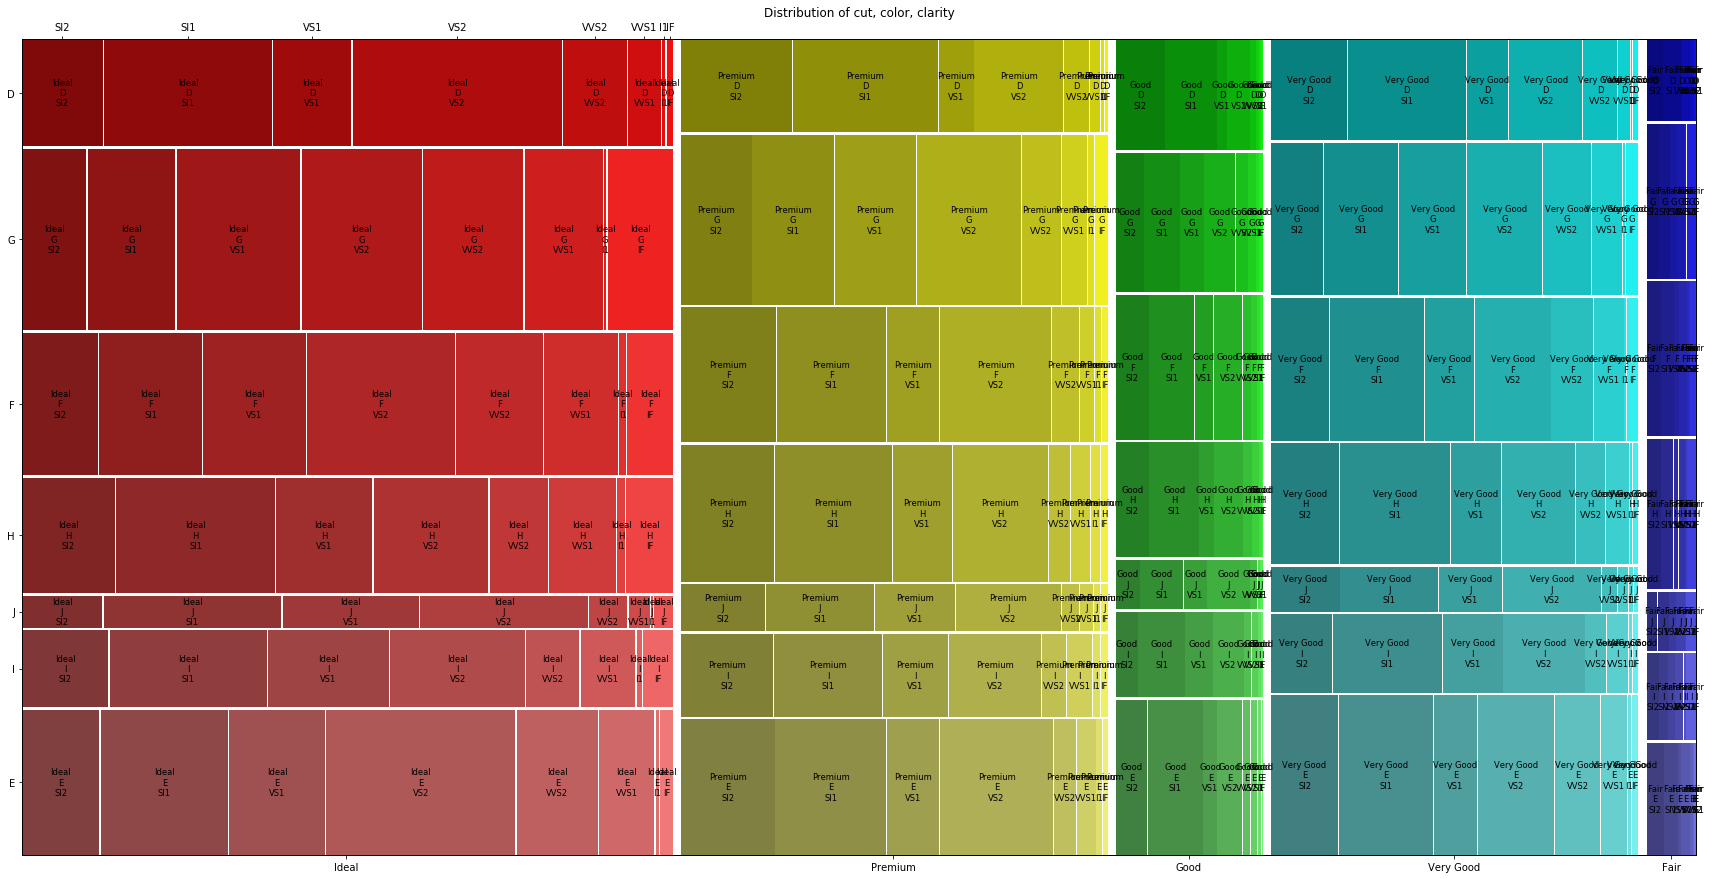

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(30,15))
mosaic(diamonds_df.toPandas(),['cut','color','clarity'],ax=axes, title='Distribution of cut, color, clarity')
 # From the plot below, we can see that there are very less number of fair diamonds in our dataset and that might be the reason why a few of them have influenced the price so much. 

#### 6. Check the distribution and relationships of numerical variables

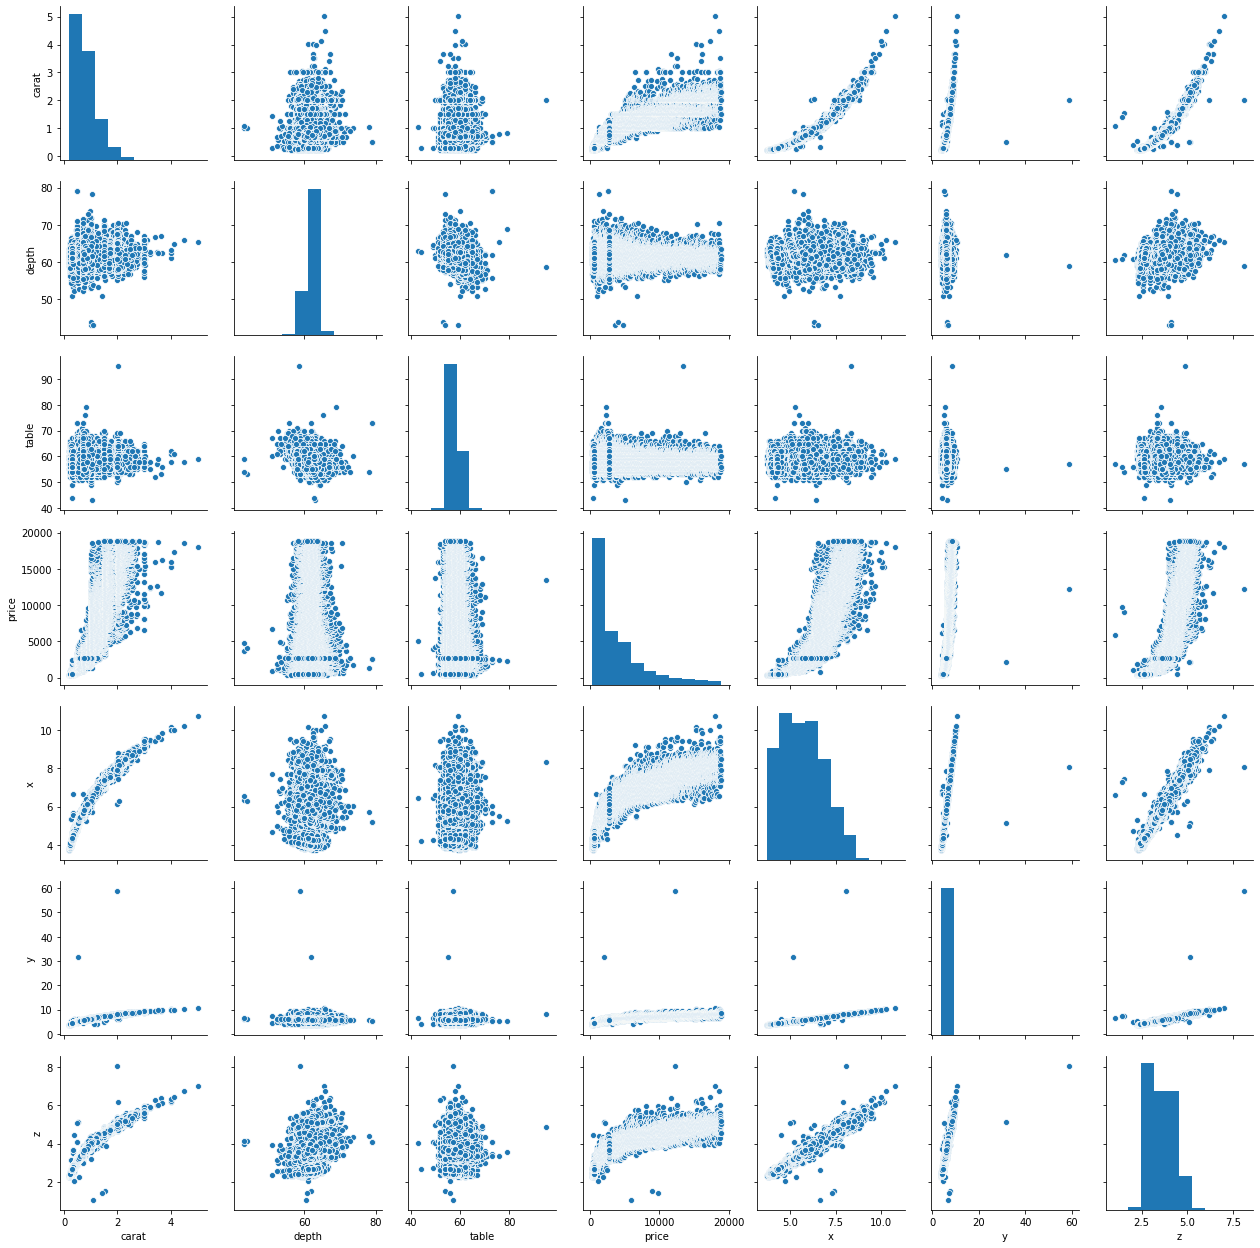

In [54]:
#We use scatter plot to check relationship and distribution of numerical variables
sns.pairplot(diamonds_df.toPandas(), kind="scatter")

###### Carat seems to have a linear relationship with Price, x and almost exponential with y and z. This seems correct as carat is calculated as weight/0.2 and x, y and z are essentially dimensions of the diamonds which will influence weight.

#### Check correlations

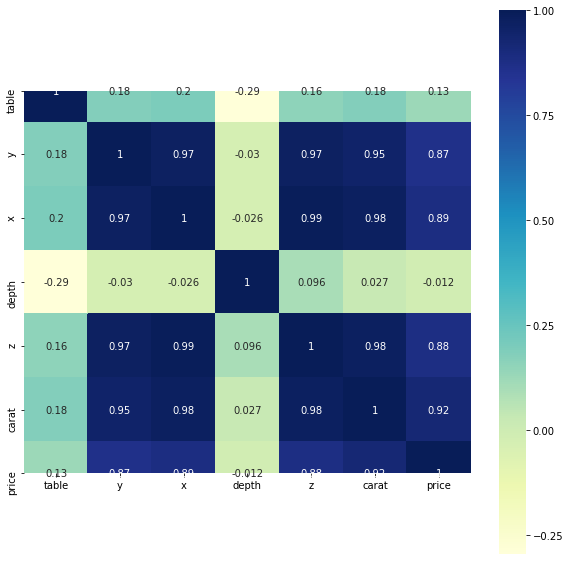

In [55]:
#Check correlations
plt.figure(figsize=(10, 10))
numeric_var = num_var+[target]
correlation = diamonds_df[numeric_var].toPandas().iloc[:, 0:].corr()
sns.heatmap(correlation, vmax=1, annot=True,square=True, cmap="YlGnBu")
#x,y,z, carat and price are hughly correlated. Some need to be removed for linear regression, to reduce multicollinearity

#### 7. Check the number of null variables in the dataset
###### There are few missing values

In [56]:
#Check for nulls for imputation
null_list = [diamonds_df.where(diamonds_df[x].isNull()).count() for x in diamonds_df.columns]
#Check number of null values
null_list
#x,y and z have some missing

[0, 0, 0, 0, 0, 0, 0, 8, 7, 20]

#### 8. Create Custom Transformer for Imputation

In [57]:
# impute missing values

class NumericImputer(Transformer, HasInputCol, HasOutputCol):

    def __init__(self, inputCol=None, outputCol=None):
        super(NumericImputer, self).__init__()
        self.setParams(inputCol = inputCol , outputCol = outputCol)

        
    def setParams(self, inputCol=None, outputCol=None):
      return self._set(inputCol = inputCol, outputCol = outputCol)
        

    def _transform(self, dataset):

      out_col = self.getOutputCol()
      in_col = self.getInputCol()
      from pyspark.sql.functions import when  
      median_v = dataset.approxQuantile(in_col, [0.5], 0)[0]
      return dataset.withColumn(out_col, when(col(in_col).isNull(), median_v).otherwise(col(in_col)))

#### 9. Create Custom z-score standardizer

In [58]:
class Standardizer(Transformer, HasInputCol, HasOutputCol):

    def __init__(self, inputCol=None, outputCol=None):
        super(Standardizer, self).__init__()
        self.setParams(inputCol = inputCol , outputCol = outputCol)
       
    def setParams(self, inputCol=None, outputCol=None):
      return self._set(inputCol = inputCol, outputCol = outputCol)
        
    def _transform(self, dataset):
      from pyspark.sql.functions import stddev, mean, col
      out_col = self.getOutputCol()
      in_col = dataset[self.getInputCol()]
      mean, sttdev = dataset.select(mean(in_col), stddev(in_col)).first()
      return dataset.withColumn(out_col, (in_col - mean)/sttdev)   

#### 10. Create ordinal encoder using UDFs for our categorical variable

In [59]:
#For ordinal encoding of categorical variables
def get_cut_labelled(cut):
  if cut=='Ideal':
    return 4
  elif cut=='Premium':
    return 3
  elif cut=='Very Good':
    return 2
  elif cut=='Good':
    return 1
  else :
    return 0
  
def get_color_labelled(color):
  if color=='D':
    return 6
  elif color=='E':
    return 5
  elif color=='F':
    return 4
  elif color=='G':
    return 3
  elif color=='H':
    return 2
  elif color=='I':
    return 1
  else :
    return 0
  
def get_clarity_labelled(clarity):
  if clarity=='IF':
    return 7
  elif clarity=='VVS1':
    return 6
  elif clarity=='VVS2':
    return 5
  elif clarity=='VS1':
    return 4
  elif clarity=='VS2':
    return 3
  elif clarity=='SI1':
    return 2
  elif clarity=='SI2':
    return 1
  else :
    return 0 

In [60]:
# Custom Ordinal Encoder
get_cut_label = udf(get_cut_labelled, IntegerType())
get_color_label = udf(get_color_labelled, IntegerType())
get_clarity_label = udf(get_clarity_labelled, IntegerType())
new_diamonds_df = diamonds_df.withColumn("cut", get_cut_label(diamonds_df["cut"]))
new_diamonds_df = new_diamonds_df.withColumn("color", get_color_label(new_diamonds_df["color"]))
new_diamonds_df = new_diamonds_df.withColumn("clarity", get_clarity_label(new_diamonds_df["clarity"]))
new_diamonds_df.head(10)

[Row(carat=0.23, cut=4, color=5, clarity=1, depth=61.5, table=55, price=326, x=3.95, y=3.98, z=2.43),
 Row(carat=0.21, cut=3, color=5, clarity=2, depth=59.8, table=61, price=326, x=3.89, y=3.84, z=2.31),
 Row(carat=0.23, cut=1, color=5, clarity=4, depth=56.9, table=65, price=327, x=4.05, y=4.07, z=2.31),
 Row(carat=0.29, cut=3, color=1, clarity=3, depth=62.4, table=58, price=334, x=4.2, y=4.23, z=2.63),
 Row(carat=0.31, cut=1, color=0, clarity=1, depth=63.3, table=58, price=335, x=4.34, y=4.35, z=2.75),
 Row(carat=0.24, cut=2, color=0, clarity=5, depth=62.8, table=57, price=336, x=3.94, y=3.96, z=2.48),
 Row(carat=0.24, cut=2, color=1, clarity=6, depth=62.3, table=57, price=336, x=3.95, y=3.98, z=2.47),
 Row(carat=0.26, cut=2, color=2, clarity=2, depth=61.9, table=55, price=337, x=4.07, y=4.11, z=2.53),
 Row(carat=0.22, cut=0, color=5, clarity=3, depth=65.1, table=61, price=337, x=3.87, y=3.78, z=2.49),
 Row(carat=0.23, cut=2, color=2, clarity=4, depth=59.4, table=61, price=338, x=4.0,

#### 11. Divide the data into test(30%) and train (70%)

In [61]:
#divide data into test and train
train, test = new_diamonds_df.randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 37267
Test Dataset Count: 15749


#### 13. Decision Tree Regressor

In [62]:
#Building stages for pipeline
input_cols=cat_var+num_var #all are numeric columns now
numericimputers = [NumericImputer(inputCol = column, outputCol = column) for column in num_var]
standardizers = [Standardizer(inputCol = column, outputCol = column) for column in input_cols] #keep only standardized columns in the dataset
assembler = VectorAssembler(inputCols= input_cols, outputCol="features")

In [63]:
#Desicion Tree regressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = target)
stages = []
stages = functools.reduce(operator.concat, [numericimputers,standardizers])
stages.append(assembler)
stages.append(dt)
#Run the spark pipeline
pipeline = Pipeline(stages=stages)
dt_model = pipeline.fit(train)
dt_predictions_test= dt_model.transform(test)
dt_predictions_train= dt_model.transform(train)
rmse_evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="r2")
r2_test_dt =r2_evaluator.evaluate(dt_predictions_test)
rmse_train_dt = rmse_evaluator.evaluate(dt_predictions_train)
rmse_test_dt = rmse_evaluator.evaluate(dt_predictions_test)
#Check performance
print("Decision Tree Model :")
print("R-squared on test data = %g" % r2_test_dt)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse_train_dt)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_test_dt)

Decision Tree Model :
R-squared on test data = 0.929279
Root Mean Squared Error (RMSE) on train data = 1090.14
Root Mean Squared Error (RMSE) on test data = 1059.5


In [64]:
#Feature Importance as per decision tree
dt_model.stages[-1].featureImportances 
#Depth , x, cut, carat,y, color are imp featured ranked in order as per the above model

SparseVector(9, {1: 0.0108, 2: 0.0551, 4: 0.2596, 5: 0.0059, 6: 0.0001, 7: 0.0033, 8: 0.6653})

###### As per the decision tree , 'table' is the most significant variable in determining the price followed by y, color, cut, z and clarity respectively

In [65]:
del stages[-1] #Delete the decison tree stage from pipeline to add a new regressor

#### 14. Gradient boosted Trees Regressor

In [66]:
#Gradient Boosted Tree regressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = target, maxIter=10)
stages.append(gbt)
#Run the spark pipeline
pipeline_gbt = Pipeline(stages=stages)
gbt_model = pipeline_gbt.fit(train)
gbt_predictions_test= gbt_model.transform(test)
gbt_predictions_train= gbt_model.transform(train)
rmse_train_gbt = rmse_evaluator.evaluate(gbt_predictions_train)
rmse_test_gbt = rmse_evaluator.evaluate(gbt_predictions_test)
r2_test_gbt =r2_evaluator.evaluate(gbt_predictions_test)
#Check performance
print("Gradient Boosted Tree Model :")
print("R-squared on test data = %g" % r2_test_gbt)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse_train_gbt)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_test_gbt)

Gradient Boosted Tree Model :
R-squared on test data = 0.953263
Root Mean Squared Error (RMSE) on train data = 803.873
Root Mean Squared Error (RMSE) on test data = 861.31


#### 15. Linear Regression Model

In [67]:
#For the linear regression model, removing the x,y and z model as they are highly correlated with carat. Amongst these 4 columns, carat shows the highest correlations with price.
input_cols_lr = list(set(input_cols) - set(['x'])-set(['y'])-set(['z']))
#standardize variables
standardizers_lr = [Standardizer(inputCol = column, outputCol = column) for column in input_cols_lr]
assembler_lr = VectorAssembler(inputCols= input_cols_lr, outputCol="features")
lr = LinearRegression(featuresCol = 'features', labelCol = target ,maxIter=10, regParam=0.3, elasticNetParam=0.8)
#Create stages for pipeline
stages_lr = []
stages_lr = functools.reduce(operator.concat, [standardizers_lr])
stages_lr.append(assembler_lr)
stages_lr.append(lr)
stages_lr

[Standardizer_bf9332ef7e84,
 Standardizer_dac2aeb54d86,
 Standardizer_3e7960626acb,
 Standardizer_e351456c9752,
 Standardizer_54a7168f29dc,
 Standardizer_86af8e96892d,
 VectorAssembler_45a490b59c13,
 LinearRegression_ac04c0af9233]

In [68]:
#divide data into test and train(for only the selected variables)
train, test = new_diamonds_df[input_cols_lr+[target]].randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 37267
Test Dataset Count: 15749


In [69]:
pipeline_lr = Pipeline(stages=stages_lr)
lr_model = pipeline_lr.fit(train)
lr_predictions_test= lr_model.transform(test)
lr_predictions_train= lr_model.transform(train)
rmse_train_lr = rmse_evaluator.evaluate(lr_predictions_train)
rmse_test_lr = rmse_evaluator.evaluate(lr_predictions_test)
r2_test_lr =r2_evaluator.evaluate(lr_predictions_test)
#Check performance
print("Linear Regression Model :")
print("R-squared on test data = %g" % r2_test_lr)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse_train_lr)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_test_lr)

Linear Regression Model :
R-squared on test data = 0.903068
Root Mean Squared Error (RMSE) on train data = 1234.48
Root Mean Squared Error (RMSE) on test data = 1243.61


In [70]:
#Coefficients for LR model
coefficients=pipeline_lr.fit(train).stages[-1].coefficients
coefficients
#coeff for depth,clarity,cut,carat,table,color respectively

DenseVector([4172.7024, 138.6425, 866.7635, -62.5821, 541.812, -58.3263])

In [71]:
#Intercept for LR model
intercept=pipeline_lr.fit(train).stages[-1].intercept
intercept

3934.8941154365734

###### Residual vs Fitted for linear regression model

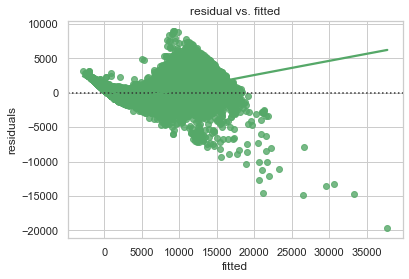

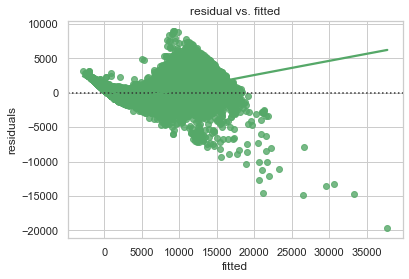

In [72]:
summary=pipeline_lr.fit(train).stages[-1].summary
# Residual vs. Fitted Plot
sns.set(style="whitegrid")
fig, ax = plt.subplots()
# Make an example dataset with y ~ x
rs = np.random.RandomState(7)
x = np.asarray(lr_predictions_train.select('prediction').toPandas())
x = x.reshape(x.shape[0])
y = np.asarray(summary.residuals.toPandas())
y = y.reshape(y.shape[0])
# Plot the residuals after fitting a linear model
sns.residplot(x, y, lowess=True, color="g")
ax.set_title('residual vs. fitted')
ax.set(xlabel='fitted', ylabel='residuals')
display(fig)